In [79]:
from dataclasses import dataclass
from typing import Any, Callable

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.collections
import matplotlib.lines
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from tqdm import tqdm

from plotting import label_axes
from utils import clamp_mod, gauss_cgs

In [80]:
T_UNIT = u.d
L_UNIT = u.au

def pack_t(q: u.Quantity[T_UNIT]) -> float:
    return q.to(T_UNIT).value

# Magnetic field

Uniform $B_0$ field in X direction with Alfven-wave perturbation with small amplitude $\delta B << B_0$


In [152]:
B0 = 1e-6 * gauss_cgs

# plasma density
n_IMP = 1 / u.cm**3
rho_IMP = n_IMP * const.m_p
v_A = (B0 / np.sqrt(rho_IMP)).to(u.km / u.s)
print(f"v_A = {v_A:.2f} ({(v_A / const.c).decompose():.2e} * speed of light)")


@dataclass
class Particle:
    E: u.Quantity[u.eV]
    theta: u.Quantity[u.rad]
    phase: u.Quantity[u.rad]
    gamma: float
    v: u.Quantity[u.km / u.s]
    R_L: u.Quantity[u.au]
    Omega_L: u.Quantity[1 / u.day]
    T_L: u.Quantity[u.day]
    k_res: u.Quantity[1 / u.au]
    w_res: u.Quantity[1 / u.kyr]
    lambda_res: u.Quantity[u.au]

    def __str__(self) -> str:
        return "\n".join(
            [
                f"proton with E = {self.E:.2f} pitch angle = {180 * self.theta.value / np.pi}",
                f"v = {self.v / const.c:.2e} c; gamma = {self.gamma:.2e}",
                f"gyration params: R = {self.R_L:.2f} T = {self.T_L:.2f}",
                f"resonance conditions: k = {self.k_res:.2e}; wavelength = {self.lambda_res:.2f}",
            ]
        )
    
    def randomize_phase(self) -> None:
        self.phase = np.random.random() * 2 * np.pi * u.rad
    
    @classmethod
    def from_energy_pitch_angle(
        cls, E: u.Quantity[u.eV], theta: u.Quantity[u.rad] | float
    ):
        if isinstance(theta, float):
            theta = theta * u.rad
        gamma = (E / (const.m_p * const.c**2)).decompose()
        v = const.c * np.sqrt(1 - gamma ** (-2))
        R_L = (
            (gamma * const.m_p * v * np.sin(theta)) * const.c / (const.e.gauss * B0)
        ).to(u.au)
        k_res = (np.tan(theta) / R_L).to(1 / u.au)
        Omega_L = v * np.sin(theta) / R_L
        return Particle(
            E=E,
            theta=theta,
            phase=np.random.random() * 2 * np.pi * u.rad,
            gamma=gamma,
            v=v,
            R_L=R_L,
            Omega_L=Omega_L,
            T_L=(2 * np.pi / Omega_L).to(u.day),
            k_res=k_res,
            w_res=(k_res * v_A).to(1 / u.kyr),
            lambda_res=1 / k_res,
        )

v_A = 7.73 km / s (2.58e-05 * speed of light)


# QLT equation for pitch angle

From Lorentz force equation on $v_z = v \mu = v \cos \theta$:

$$
\frac{ d \theta }{ dt } = - \Omega \frac{\delta B}{B} \cos( \phi + \Omega t - k z(t) )
$$

We must add an equation for $z(t)$ to form a system of 2 differential equations:

$$
\frac{dz}{dt} = v \cos(\theta(t))
$$

The resulting ODE system for the vector $(\theta, z)$ is solved numerically.

In [222]:
from typing import Literal


@dataclass
class MagneticFieldPerturbation:
    deltaB: u.Quantity[gauss_cgs]
    k: u.Quantity[1 / u.au]
    phase: np.ndarray

    def n_harmonics(self) -> int:
        return self.deltaB.size

    def __post_init__(self) -> None:
        assert self.deltaB.size == self.k.size
        assert self.k.size == self.phase.size

    def plot(self, ax: plt.Axes, z: u.Quantity[u.au]) -> None:
        dB = np.expand_dims(self.deltaB, axis=1)
        k = np.expand_dims(self.k, axis=1)
        phi = np.expand_dims(self.phase, axis=1)
        z_reshaped = z.reshape((1, z.size))
        res = np.sum(dB * np.cos(phi + (k * z_reshaped).decompose().value), axis=0)
        ax.plot(z, res)

    def resonant_angles(self, particle: Particle) -> u.Quantity[u.rad]:
        return np.arctan(particle.R_L * self.k)

    def plot_resonant_angles(
        self, ax: plt.Axes, particle: Particle, axis: Literal["x", "y"]
    ) -> None:
        get_lim, line = (
            (ax.get_xlim, ax.axvline) if axis == "x" else (ax.get_ylim, ax.axhline)
        )
        theta_min, theta_max = get_lim()
        for theta_res in self.resonant_angles(particle):
            if theta_min < theta_res.to(u.deg).value < theta_max:
                line(theta_res, color="k", linestyle="--", linewidth=0.5)

    @classmethod
    def comb(
        cls,
        particle: Particle,
        theta_halfwidth: u.Quantity[u.rad],
        deltaB_mono: u.Quantity[gauss_cgs],
        n_harmonics: int,
    ) -> "MagneticFieldPerturbation":
        small_angle = 10 * u.deg
        theta_min = max(particle.theta - theta_halfwidth, small_angle)
        theta_max = min(particle.theta + theta_halfwidth, 90 * u.deg - small_angle)
        return MagneticFieldPerturbation(
            deltaB=(deltaB_mono / np.sqrt(n_harmonics)) * np.ones(shape=(n_harmonics)),
            k=(
                np.linspace(np.tan(theta_min), np.tan(theta_max), num=n_harmonics)
                / particle.R_L
            ),
            phase=np.random.random(size=n_harmonics) * 2 * np.pi,
        )


HarmonicSelector = Literal["all", "resonant", "non-resonant"] | int


def get_theta_rhs(
    particle: Particle,
    mf: MagneticFieldPerturbation,
    harmonic_selector: HarmonicSelector = "all",
) -> Callable:

    def mu_rhs(
        t: float, params: np.ndarray, pbar: tqdm | None = None, verbose: bool = False
    ) -> np.ndarray:
        if pbar is not None:
            pbar.update()
        t = t * T_UNIT
        theta, z = params
        if verbose:
            print(f"t={t:.4e} theta={theta:.4e} z={z:.4e}")
        z: u.Quantity = z * L_UNIT

        harmonics_mask = np.ones((mf.n_harmonics(),), dtype=bool)
        true_k_res = np.tan(theta) / particle.R_L
        resonant_harmonic_idx = np.argmin(np.abs(mf.k - true_k_res))
        if harmonic_selector == "resonant":
            harmonics_mask[:] = False
            harmonics_mask[resonant_harmonic_idx] = True
        elif harmonic_selector == "non-resonant":
            harmonics_mask[resonant_harmonic_idx] = False
        elif isinstance(harmonic_selector, int):
            harmonics_mask[:] = False
            start = max(resonant_harmonic_idx - harmonic_selector, 0)
            end = min(resonant_harmonic_idx + 1 + harmonic_selector, mf.n_harmonics())
            harmonics_mask[start:end] = True

        theta_dot = np.sum(
            (
                -particle.Omega_L
                * (mf.deltaB[harmonics_mask] / B0)
                * np.cos(
                    mf.phase[harmonics_mask]
                    + particle.phase.value
                    + (particle.Omega_L * t).decompose().value
                    - (mf.k[harmonics_mask] * z).decompose().value
                )
            )
            .to(1 / T_UNIT)
            .value
        )
        z_dot = (particle.v * np.cos(theta)).to(L_UNIT / T_UNIT).value
        result = np.array([theta_dot, z_dot])
        if verbose:
            print(f"theta dot={theta_dot:.4e} z_dot={z_dot:.4e}")
        return result

    return mu_rhs

In [223]:
@dataclass
class PitchAngleTrajectory:
    t: u.Quantity[u.d]
    theta: u.Quantity[u.deg]
    theta_dot: u.Quantity[u.deg / T_UNIT]
    z: u.Quantity[L_UNIT]
    z_dot: u.Quantity[L_UNIT / T_UNIT]

    particle: Particle
    mf_params: MagneticFieldPerturbation
    solution: Any

    description: str | None = None

    @classmethod
    def from_solution(
        cls, solution: Any, p: Particle, mf: MagneticFieldPerturbation, rhs: Callable
    ) -> "PitchAngleTrajectory":
        rhs_val = np.array(
            [rhs(t, params) for t, params in zip(solution.t, solution.y.T)]
        )
        return PitchAngleTrajectory(
            solution=solution,
            particle=p,
            mf_params=mf,
            t=solution.t * T_UNIT,
            theta=(180 * solution.y[0, :] / np.pi) * u.deg,
            z=solution.y[1, :] * L_UNIT,
            theta_dot=rhs_val[:, 0] * (u.rad / T_UNIT),
            z_dot=rhs_val[:, 1] * (L_UNIT / T_UNIT),
        )

    def plot_theta(self, ax: plt.Axes, **plot_kw) -> None:
        ax.plot(
            (self.t / self.particle.T_L).decompose(),
            self.theta,
            label=self.description,
            **plot_kw,
        )

    def plot_delta_z(self, ax: plt.Axes, **plot_kw) -> None:
        z_lin = self.particle.v * np.cos(self.particle.theta) * self.t
        ax.plot(
            (self.t / self.particle.T_L).decompose(),
            (self.z - z_lin).to(L_UNIT),
            label=self.description,
            **plot_kw,
        )

    def plot_rhs_phase(self, ax: plt.Axes, **plot_kw) -> None:
        phase = (
            self.mf_params.phase_diff
            + (self.particle.Omega_L * self.t).decompose().value
            - (self.mf_params.k * self.z).decompose().value
        ) / np.pi
        t = (self.t / self.particle.T_L).decompose()
        wrapped, n_period = clamp_mod(phase, min=-1, period=2)
        switch_idx = np.nonzero(np.diff(n_period))[0]
        starts = np.concatenate(([0], switch_idx + 1))
        ends = np.concatenate((switch_idx + 1, [len(n_period)]))
        color = plot_kw.pop("color", None)
        for idx, (s, e) in enumerate(zip(starts, ends)):
            line, *_ = ax.plot(
                t[s:e],
                wrapped[s:e],
                label=self.description if idx == 0 else None,
                color=color,
                **plot_kw,
            )
            if color is None:
                color = line.get_color()

    def plot_phase_space(
        self,
        ax: plt.Axes,
        add_colorbar: bool = True,
        resize: bool = True,
        color: Any | None = None,
    ) -> None:
        x = self.theta.to(u.deg).value
        y = self.theta_dot.to(u.deg / u.d).value

        if color is None:
            x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
            y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))
            coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[
                :, np.newaxis, :
            ]
            coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
            coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
            segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

            lc = matplotlib.collections.LineCollection(segments)
            lc.set_array((self.t / self.particle.T_L).decompose())

            ax.add_collection(lc)
            if add_colorbar:
                plt.colorbar(lc, label="t / $T_L$")

            if resize:
                extent = 0.05
                for arr, setlim, getlim in zip(
                    (x, y), (ax.set_xlim, ax.set_ylim), (ax.get_xlim, ax.get_ylim)
                ):
                    min_ = arr.min()
                    max_ = arr.max()
                    width = max_ - min_
                    setlim(min_ - extent * width, max_ + extent * width)
        else:
            ax.plot(x, y, color=color)

        ax.axhline(0, color="k", linestyle="--", linewidth=0.5)
        ax.axvline(
            self.particle.theta.to(u.deg).value,
            color="k",
            linestyle="--",
            linewidth=0.5,
        )
        ax.set_xlabel("$ \\theta $ [deg]")
        ax.set_ylabel("$ \\dot \\theta $ [deg/day]")

In [224]:
particle = Particle.from_energy_pitch_angle(E=100 * u.GeV, theta=np.pi / 3)
print(particle)

proton with E = 100.00 GeV pitch angle = 59.99999999999999
v = 1.00e+00 c; gamma = 1.07e+02
gyration params: R = 19.31 AU T = 0.81 d
resonance conditions: k = 8.97e-02 1 / AU; wavelength = 11.15 AU


In [225]:
def get_solve_ivp_kwargs(n_T_L: int, particle: Particle) -> dict[str, Any]:
    t_max = n_T_L * particle.T_L
    t_step = particle.T_L / 17.812
    t_eval = np.linspace(0, t_max, int(t_max / t_step))
    return dict(
        t_span=(0, pack_t(t_max)),
        y0=np.array([particle.theta.to(u.rad).value, 0]),
        t_eval=pack_t(t_eval),
        # method="Radau",
        max_step=pack_t(t_step),
    )

# Sanity check

Is it reasonable to assume that only closest resonant $k$ is important for particle movement?

16058it [00:02, 6317.32it/s]
16058it [00:02, 6432.99it/s]
16058it [00:02, 6391.39it/s]
16058it [00:02, 6493.26it/s]
16058it [00:02, 6387.19it/s]
16058it [00:02, 6475.55it/s]


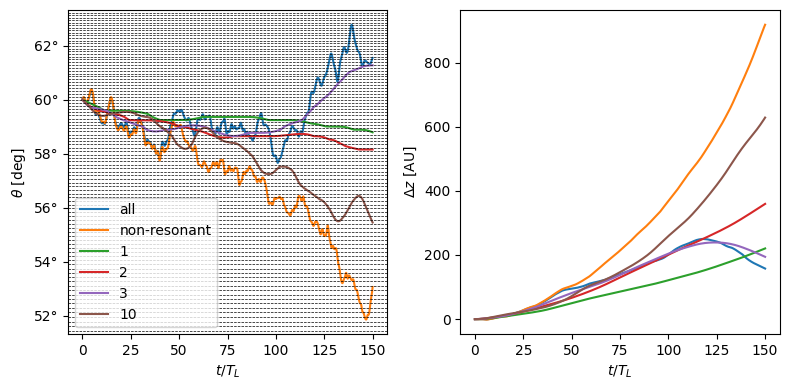

In [229]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax_theta = axes[0]
ax_z = axes[1]

n_T_L = 150
mf = MagneticFieldPerturbation.comb(
    particle=particle,
    deltaB_mono=1e-3 * B0,
    n_harmonics=200,
    theta_halfwidth=10 * u.deg,
)
particle_phase = 0

solve_ivp_kw = get_solve_ivp_kwargs(n_T_L, particle)
selectors: list[HarmonicSelector] = ["all", "non-resonant", 1, 2, 3, 10]
for hs in selectors:
    rhs = get_theta_rhs(particle=particle, mf=mf, harmonic_selector=hs)
    with tqdm() as pbar:
        solution = solve_ivp(rhs, args=[pbar, False], **solve_ivp_kw)
    t = PitchAngleTrajectory.from_solution(
        solution=solution, p=particle, mf=mf, rhs=rhs
    )
    t.description = str(hs)
    t.plot_theta(ax_theta)
    t.plot_delta_z(ax_z)

mf.plot_resonant_angles(ax_theta, particle, axis="y")

label_axes(ax_theta, "t / T_L", "\\theta")
ax_theta.legend()
label_axes(ax_z, "t / T_L", "\\Delta z")
# ax_theta.set_ylim(57, 63)
plt.tight_layout()
plt.show()

# Simulating pitch angle diffusion and measuring $D_{\theta \theta}$

100%|██████████| 100/100 [04:33<00:00,  2.74s/it]


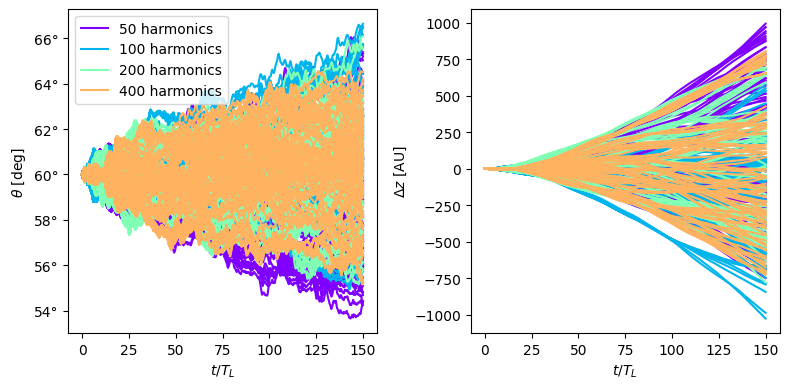

In [230]:
from tqdm import trange


fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax_theta = axes[0]
ax_z = axes[1]

n_T_L = 150
n_phases = 100
mfs = [
    MagneticFieldPerturbation.comb(
        particle=particle,
        deltaB_mono=1e-3 * B0,
        n_harmonics=n_harmonics,
        theta_halfwidth=15 * u.deg,
    )
    for n_harmonics in [50, 100, 200, 400]
]


solve_ivp_kw = get_solve_ivp_kwargs(n_T_L, particle)
trajectory_series: list[list[PitchAngleTrajectory]] = []
cmap = matplotlib.colormaps["rainbow"]
for resonant_harmonic_idx, mf in enumerate(mfs):
    color = cmap(resonant_harmonic_idx / len(mfs))

    trajectories: list[PitchAngleTrajectory] = []
    for resonant_harmonic_idx in trange(n_phases):
        particle.randomize_phase()
        rhs = get_theta_rhs(particle=particle, mf=mf, harmonic_selector="all")
        solution = solve_ivp(rhs, args=[None, False], **solve_ivp_kw)
        t = PitchAngleTrajectory.from_solution(
            solution=solution, p=particle, mf=mf, rhs=rhs
        )
        if resonant_harmonic_idx == 0:
            t.description = f"{mf.deltaB.size} harmonics"
        t.plot_theta(ax_theta, color=color)
        t.plot_delta_z(ax_z, color=color)
        trajectories.append(t)

    trajectory_series.append(trajectories)

label_axes(ax_theta, "t / T_L", "\\theta")
ax_theta.legend()
label_axes(ax_z, "t / T_L", "\\Delta z")
plt.tight_layout()
plt.show()

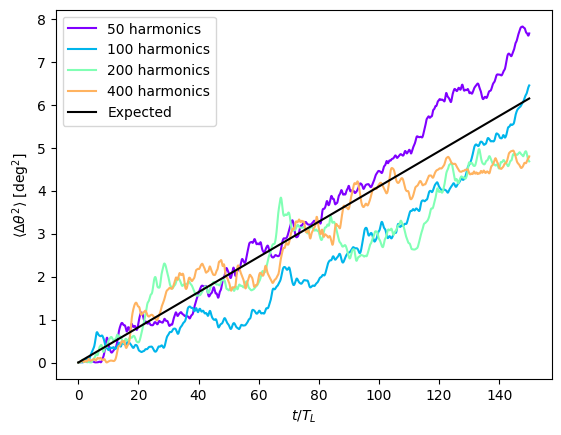

In [243]:
fig, ax = plt.subplots()
ax: plt.Axes

for resonant_harmonic_idx, (mf, trajectories) in enumerate(zip(mfs, trajectory_series)):
    color = cmap(resonant_harmonic_idx / len(trajectory_series))
    n_harmonics = mf.deltaB.size
    thetas_ensemble = np.vstack(tuple(t.theta for t in trajectories))
    thetas_ensemble -= np.mean(thetas_ensemble, axis=0)
    t = trajectories[0].t
    ax.plot(
        t / particle.T_L,
        np.mean(thetas_ensemble**2, axis=0),
        label=f"{n_harmonics} harmonics",
        color=color,
    )

    delta_k_mean = np.mean(np.diff(mf.k))
    # ax.plot(
    #     t / particle.T_L,
    #     particle.Omega_L
    #     * ((mf.deltaB[0]) / B0).decompose()
    #     * (delta_k_mean / particle.k_res)
    #     / np.tan(particle.theta)
    #     * t
    #     * u.rad**2,
    #     color=color,
    #     linestyle="--",
    # )

ax.plot(
    t / particle.T_L,
    (np.pi)
    * particle.Omega_L
    * ((mf.deltaB[0]) / B0).decompose() ** 2
    * (particle.k_res / delta_k_mean)
    * t
    * u.rad**2,
    color="k",
    label=f"Expected",
)

label_axes(ax, "t / T_L", "\\langle \\Delta \\theta^2 \\rangle")
# ax.set_yscale("log")
ax.legend()
plt.show()